# Modeling

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [1]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(96397, 25)
Wall time: 213 ms


,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60,...,card_zip3_avg_0,card_zip_avg_0,Merchnum_desc_med_0,Merchnum_desc_avg_0,Merchnum_desc_avg_1,merch_zip_med_0,Merchnum_med_0,Merchnum_avg_1,Recnum,Fraud
0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,0


In [3]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_zip_total_14',
 'card_zip3_max_30',
 'Card_Merchnum_desc_total_0',
 'card_zip3_max_60',
 'card_merch_total_60',
 'card_zip_max_60',
 'Card_Merchnum_desc_max_60',
 'card_zip_total_30',
 'card_merch_avg_0',
 'card_zip3_total_60']

In [4]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24


In [5]:
vars.shape

(96397, 12)

In [6]:
vars['Fraud'].sum()

1059

In [7]:
vars.head(10)

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
0,1,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,7.24,3.62,7.24,3.62,3.62,7.24,3.62,7.24
5,6,0,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67,3.67
6,7,0,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,10.86,3.62,10.86,3.62,3.62,10.86,3.62,10.86


In [8]:
vars.shape

(96397, 12)

In [9]:
vars.describe()

,Recnum,Fraud,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.0000,96397.000000,96397.000000
mean,48365.481820,0.010986,806.656625,591.548408,524.640338,662.723920,1141.217228,583.064911,542.037643,992.1012,395.812357,1631.561943
std,27945.003883,0.104236,4186.923501,1136.743057,2617.102844,1196.229282,4551.733037,1121.768638,1090.108775,4346.6019,796.953627,5108.927755
min,1.000000,0.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.0100,0.010000,0.010000
25%,24154.000000,0.000000,85.000000,69.450000,43.400000,83.540000,108.810000,69.450000,50.450000,105.7500,34.990000,165.520000
50%,48365.000000,0.000000,257.000000,255.850000,155.000000,300.000000,348.790000,249.970000,216.970000,322.7800,141.000000,516.790000
75%,72578.000000,0.000000,718.640000,717.810000,492.000000,852.000000,1023.040000,705.020000,645.000000,906.2700,435.300000,1516.500000
max,96753.000000,1.000000,306633.410000,47900.000000,217467.180000,47900.000000,306633.410000,47900.000000,47900.000000,306633.4100,28392.840000,306633.410000


In [10]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [11]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.0000,96397.000000,96397.000000
mean,806.656625,591.548408,524.640338,662.723920,1141.217228,583.064911,542.037643,992.1012,395.812357,1631.561943
std,4186.923501,1136.743057,2617.102844,1196.229282,4551.733037,1121.768638,1090.108775,4346.6019,796.953627,5108.927755
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.0100,0.010000,0.010000
25%,85.000000,69.450000,43.400000,83.540000,108.810000,69.450000,50.450000,105.7500,34.990000,165.520000
50%,257.000000,255.850000,155.000000,300.000000,348.790000,249.970000,216.970000,322.7800,141.000000,516.790000
75%,718.640000,717.810000,492.000000,852.000000,1023.040000,705.020000,645.000000,906.2700,435.300000,1516.500000
max,306633.410000,47900.000000,217467.180000,47900.000000,306633.410000,47900.000000,47900.000000,306633.4100,28392.840000,306633.410000


In [12]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [13]:
# use this to cap variables. For some problems it helps
Clip = 10

In [14]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-1.385046e-15,6.821759e-15,-1.274005e-15,6.270961e-15,1.678860e-15,1.266896e-14,-1.410837e-15,-2.322741e-15,1.116460e-14,-2.196757e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.926586e-01,-5.203800e-01,-2.004623e-01,-5.540024e-01,-2.507193e-01,-5.197640e-01,-4.972234e-01,-2.282452e-01,-4.966442e-01,-3.193531e-01
25%,-1.723596e-01,-4.592932e-01,-1.838829e-01,-4.841747e-01,-2.268163e-01,-4.578617e-01,-4.509528e-01,-2.039182e-01,-4.527520e-01,-2.869569e-01
50%,-1.312794e-01,-2.953160e-01,-1.412403e-01,-3.032227e-01,-1.740935e-01,-2.969373e-01,-2.981974e-01,-1.539872e-01,-3.197330e-01,-2.182008e-01
75%,-2.102179e-02,1.110731e-01,-1.247194e-02,1.582273e-01,-2.596313e-02,1.087168e-01,9.445145e-02,-1.974674e-02,4.954823e-02,-2.252174e-02
max,7.304331e+01,4.161754e+01,8.289416e+01,3.948848e+01,6.711558e+01,4.218065e+01,4.344334e+01,7.031730e+01,3.513006e+01,5.969978e+01


In [15]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=84300
X_trntst = X[3346:oot_recnum]
Y_trntst = Y_save[3346:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [16]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [17]:
alphas = 10**np.linspace(2,9,30)*0.5

In [18]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [19]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

Wall time: 236 ms


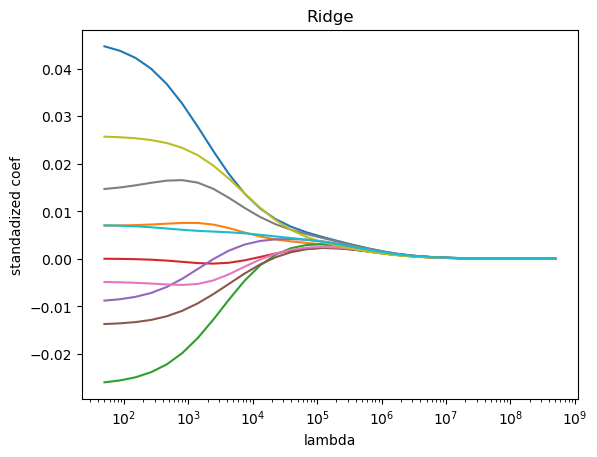

In [20]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [21]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [22]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
Wall time: 4.54 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


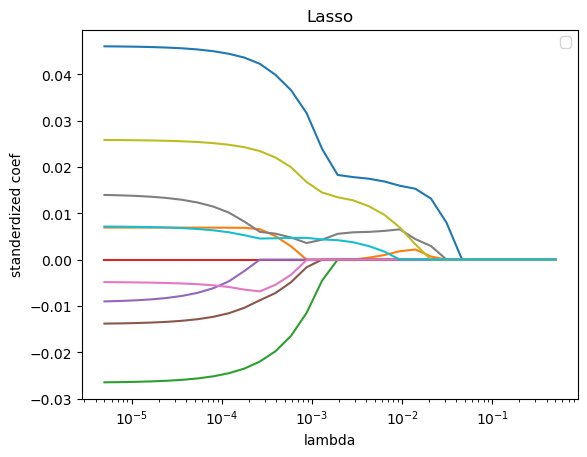

In [23]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [24]:
len(X_trntst.columns)

10

In [25]:
X_trntst_save = X_trntst.copy()

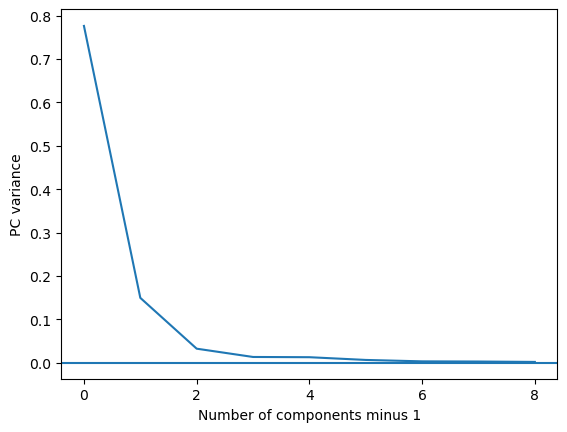

In [26]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [27]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-1.095141,0.442001,-0.109618,-0.018156
1,0.023565,-0.329359,-0.286885,0.031875
2,0.620863,-0.043892,0.407541,-0.481362
3,-1.154191,0.482717,-0.100261,-0.020797
4,0.157974,-0.422035,-0.308183,0.037886


In [28]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
84300,-0.044457,-0.307359,0.814129,0.612453
84301,-0.983115,0.396784,-0.030610,-0.019161
84302,2.561691,-2.030857,-0.664916,0.156159
84303,-0.816843,0.265708,-0.135409,0.008891
84304,-0.086602,-0.253398,-0.269429,0.026948


In [29]:
X_trntst.describe()

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60
count,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000,80954.000000
mean,0.004940,0.008906,0.003829,0.009051,0.008350,0.008054,0.008306,0.007113,0.005194,0.010170
std,1.075898,1.020808,1.075751,1.020535,1.064416,1.022566,1.025707,1.070998,1.002813,1.056045
min,-0.192659,-0.520380,-0.200462,-0.554002,-0.250719,-0.519764,-0.497223,-0.228245,-0.496644,-0.319353
25%,-0.172178,-0.460745,-0.184586,-0.484361,-0.225744,-0.458330,-0.452283,-0.203169,-0.455500,-0.285101
50%,-0.130563,-0.293389,-0.142163,-0.300071,-0.171250,-0.296911,-0.296909,-0.151765,-0.320291,-0.213573
75%,-0.019525,0.128812,-0.013236,0.178708,-0.018839,0.122071,0.103625,-0.015259,0.054191,-0.015182
max,73.043311,41.617542,82.894159,39.488480,67.115578,42.180654,43.443337,70.317300,35.130059,59.699777


In [30]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.073533,0.006550,0.005588,-0.000875
std,1.977980,1.062535,0.598189,0.359470
min,-1.193388,-33.800074,-10.458435,-10.600675
25%,-1.017268,-0.140931,-0.173178,-0.023106
50%,-0.654740,0.250081,-0.105371,-0.010450
75%,0.191501,0.431853,0.009575,0.034653
max,54.647940,5.253966,15.724932,10.224087


In [31]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [32]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.095400e+04,8.095400e+04,8.095400e+04,8.095400e+04
mean,-3.776300e-16,5.943754e-17,2.762927e-16,9.738897e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.103326e-01,-3.552975e+01,-2.307385e+01,-3.065457e+01
25%,-3.504079e-01,-1.270939e-01,-2.915129e-01,-6.213118e-02
50%,-2.356366e-01,2.026937e-01,-1.695891e-01,-2.948646e-02
75%,6.890214e-02,3.519024e-01,3.103245e-02,8.462731e-02
max,5.227550e+01,5.323181e+01,3.085848e+01,3.440005e+01


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12097.000000,12097.000000,12097.000000,12097.000000
mean,-0.025284,0.005130,0.009393,-0.002291
std,0.680106,0.832180,1.005576,0.941638
min,-0.410333,-26.472306,-17.580967,-27.768681
25%,-0.349776,-0.110378,-0.291118,-0.060527
50%,-0.225125,0.195864,-0.177133,-0.027375
75%,0.065845,0.338229,0.016096,0.090775
max,18.790065,4.114920,26.434121,26.782202


In [34]:
X_trntst_pca.shape

(80954, 4)

In [35]:
X_oot_orig_pca.shape

(12097, 4)

## Subsample the larger class if desired

In [36]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010722138498406503
(1727, 10) 1727


In [37]:
niter = 0
nitermax = 10
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [38]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [39]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20, penalty='elasticnet', C=1, solver='saga',l1_ratio=0.4)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.6683168316831684 0.6145038167938931 0.4245810055865922
1 0.6711409395973155 0.6139705882352942 0.40782122905027934


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2 0.6486928104575164 0.66015625 0.4245810055865922
3 0.6602254428341385 0.631578947368421 0.41899441340782123


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


4 0.6302521008403361 0.6959706959706959 0.41899441340782123
5 0.6447811447811448 0.6678832116788321 0.41899441340782123
6 0.6590538336052202 0.6196078431372549 0.39664804469273746


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


7 0.6661045531197302 0.6290909090909091 0.441340782122905
8 0.650088809946714 0.6622950819672131 0.43575418994413406
9 0.6589403973509934 0.6439393939393939 0.4022346368715084
trn    0.655760
tst    0.643900
oot    0.418994
dtype: float64
Wall time: 1.89 s


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [40]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='gini',max_depth=30,min_samples_split=5,min_samples_leaf=5, max_features=10, splitter='best')
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 1.0 0.7071428571428572 0.4972067039106145
1 1.0 0.669260700389105 0.45251396648044695
2 1.0 0.6933797909407665 0.3743016759776536
3 0.9983922829581994 0.6910569105691057 0.4245810055865922
4 0.9982847341337907 0.6666666666666666 0.3854748603351955
5 1.0 0.6804511278195489 0.2849162011173184
6 1.0 0.6681034482758621 0.4692737430167598
7 1.0 0.7318840579710145 0.45251396648044695
8 1.0 0.7558139534883721 0.33519553072625696
9 1.0 0.6837944664031621 0.4748603351955307
trn    0.999668
tst    0.694755
oot    0.415084
dtype: float64
Wall time: 5.1 s


In [41]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(criterion='gini', n_estimators=100,max_depth=30,min_samples_split=5,min_samples_leaf=5,max_features=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 1.0 0.8452380952380952 0.5754189944134078
1 1.0 0.8390804597701149 0.5027932960893855
2 1.0 0.7857142857142857 0.5418994413407822
3 1.0 0.7888888888888889 0.5251396648044693
4 1.0 0.8306451612903226 0.5251396648044693
5 1.0 0.7984790874524715 0.547486033519553
6 1.0 0.7992565055762082 0.5586592178770949
7 1.0 0.7950819672131147 0.5642458100558659
8 1.0 0.7718631178707225 0.5363128491620112
9 1.0 0.8326693227091634 0.5642458100558659
trn    1.000000
tst    0.808692
oot    0.544134
dtype: float64
Wall time: 4min 52s


In [42]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(n_estimators=1000,num_leaves=10, max_depth=6, learning_rate=0.1, boosting_type='gbdt')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 1.0 0.8148148148148148 0.44692737430167595
1 1.0 0.8221343873517787 0.35195530726256985
2 0.9983818770226537 0.792 0.39664804469273746
3 1.0 0.7553956834532374 0.3743016759776536
4 1.0 0.7547169811320755 0.4245810055865922
5 1.0 0.8044280442804428 0.4022346368715084
6 1.0 0.7406015037593985 0.5251396648044693
7 1.0 0.7470817120622568 0.45251396648044695
8 1.0 0.7613636363636364 0.48044692737430167
9 1.0 0.8051470588235294 0.5027932960893855
trn    0.999838
tst    0.779768
oot    0.435754
dtype: float64
Wall time: 7.14 s


In [43]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(20, 20, 20), activation='logistic', alpha=0.0001, learning_rate='adaptive', solver='lbfgs', learning_rate_init=0.0001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0 0.7577235772357723 0.7391304347826086 0.5586592178770949
1 0.7508532423208191 0.7411347517730497 0.547486033519553
2 0.74481658692185 0.6721991701244814 0.5586592178770949
3 0.486088379705401 0.5058365758754864 0.329608938547486
4 0.0032948929159802307 0.0038314176245210726 0.00558659217877095
5 0.7095709570957096 0.6984732824427481 0.5195530726256983
6 0.7278688524590164 0.7170542635658915 0.5363128491620112


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


7 0.7779632721202003 0.7137546468401487 0.2681564245810056


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


8 0.7591362126245847 0.7593984962406015 0.5754189944134078
9 0.7556270096463023 0.7317073170731707 0.3128491620111732
trn    0.647294
tst    0.628252
oot    0.421229
dtype: float64
Wall time: 60 s


C:\Users\Qianye Yin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [44]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 nan nan 0.24581005586592178
1 nan nan 0.3016759776536313
2 nan nan 0.24581005586592178
3 nan nan 0.25139664804469275
4 nan nan 0.26256983240223464
5 nan nan 0.22346368715083798
6 nan nan 0.21787709497206703
7 nan nan 0.2569832402234637
8 nan nan 0.33519553072625696
9 nan nan 0.22905027932960895
trn         NaN
tst         NaN
oot    0.256983
dtype: float64
Wall time: 10.6 s


In [45]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(n_estimators=1000, max_depth=6,learning_rate=0.1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9965811965811966 0.8197879858657244 0.5586592178770949
1 0.9983333333333333 0.8134328358208955 0.547486033519553
2 0.9950331125827815 0.8712121212121212 0.5586592178770949
3 1.0 0.85 0.4581005586592179
4 0.9983579638752053 0.7837837837837838 0.5251396648044693
5 1.0 0.8223938223938224 0.5363128491620112
6 0.9881154499151104 0.8136200716845878 0.5586592178770949
7 0.9966101694915255 0.8309352517985612 0.3575418994413408
8 0.9966777408637874 0.8082706766917294 0.5363128491620112
9 0.9983079526226735 0.8050541516245487 0.5642458100558659
trn    0.996802
tst    0.821849
oot    0.520112
dtype: float64
Wall time: 30min 49s


In [46]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6677115987460815 0.6521739130434783 0.46368715083798884
1 0.6592082616179001 0.662020905923345 0.48044692737430167
2 0.6480541455160744 0.6823104693140795 0.4860335195530726
3 0.6758957654723127 0.6141732283464567 0.48044692737430167
4 0.6726677577741408 0.6264591439688716 0.4748603351955307
5 0.6737704918032786 0.6395348837209303 0.441340782122905
6 0.6470588235294118 0.69921875 0.48044692737430167
7 0.6566666666666666 0.6791044776119403 0.4692737430167598
8 0.6745283018867925 0.6206896551724138 0.48044692737430167
9 0.6525974025974026 0.6746031746031746 0.4692737430167598
trn    0.662816
tst    0.655029
oot    0.472626
dtype: float64
Wall time: 920 ms


In [47]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

92.26497695852534
0 0.6382488479262672 0.6382488479262672 0.41899441340782123
1 0.6463133640552995 0.6463133640552995 0.46368715083798884
2 0.5483870967741935 0.5483870967741935 0.22346368715083798
3 0.6025345622119815 0.6025345622119815 0.4245810055865922
4 0.630184331797235 0.630184331797235 0.5251396648044693
5 0.6417050691244239 0.6417050691244239 0.553072625698324
6 0.6762672811059908 0.6762672811059908 0.5363128491620112
7 0.630184331797235 0.630184331797235 0.3407821229050279
8 0.6336405529953917 0.6336405529953917 0.46368715083798884
9 0.6578341013824884 0.6578341013824884 0.5195530726256983
trn    0.630530
tst    0.630530
oot    0.446927
dtype: float64
Wall time: 676 ms


In [48]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 nan nan 0.3687150837988827
1 nan nan 0.3407821229050279
2 nan nan 0.3743016759776536
3 nan nan 0.3575418994413408
4 nan nan 0.3687150837988827
5 nan nan 0.4581005586592179
6 nan nan 0.36312849162011174
7 nan nan 0.5139664804469274
8 nan nan 0.4581005586592179
9 nan nan 0.3687150837988827
trn         NaN
tst         NaN
oot    0.397207
dtype: float64
Wall time: 694 ms


In [49]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 nan nan 0.29608938547486036
1 nan nan 0.29608938547486036
2 nan nan 0.29608938547486036
3 nan nan 0.29608938547486036
4 nan nan 0.29608938547486036
5 nan nan 0.29608938547486036
6 nan nan 0.29608938547486036
7 nan nan 0.29608938547486036
8 nan nan 0.29608938547486036
9 nan nan 0.29608938547486036
trn         NaN
tst         NaN
oot    0.296089
dtype: float64
Wall time: 231 ms


In [50]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(n_estimators=1000,max_depth=6, alpha=1, booster='gbtree')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.9983108108108109 0.7753623188405797 0.5642458100558659
1 0.9983633387888707 0.8404669260700389 0.46368715083798884
2 1.0 0.8346153846153846 0.5083798882681564
3 0.9948805460750854 0.8191489361702128 0.4301675977653631
4 0.9983579638752053 0.8262548262548263 0.4134078212290503
5 0.995334370139969 0.8 0.5307262569832403
6 0.9966722129783694 0.8089887640449438 0.4692737430167598
7 0.9983870967741936 0.8467741935483871 0.5698324022346368
8 0.9967051070840197 0.8237547892720306 0.5195530726256983
9 1.0 0.7883817427385892 0.36312849162011174
trn    0.997701
tst    0.816375
oot    0.483240
dtype: float64
Wall time: 38 s


In [51]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [52]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [53]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.668317,0.614504,0.424581
1,log reg,0.671141,0.613971,0.407821
2,log reg,0.648693,0.660156,0.424581
3,log reg,0.660225,0.631579,0.418994
4,log reg,0.630252,0.695971,0.418994
5,log reg,0.644781,0.667883,0.418994
6,log reg,0.659054,0.619608,0.396648
7,log reg,0.666105,0.629091,0.441341
8,log reg,0.650089,0.662295,0.435754
9,log reg,0.65894,0.643939,0.402235


In [54]:
df.shape

(90, 4)

In [55]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.668317
1,log reg,Trn,0.671141
2,log reg,Trn,0.648693
3,log reg,Trn,0.660225
4,log reg,Trn,0.630252


In [56]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.668317
1,log reg,Trn,0.671141
2,log reg,Trn,0.648693
3,log reg,Trn,0.660225
4,log reg,Trn,0.630252


In [57]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
                       mean       std      mean       std      mean       std
Model                                                                        
DT                 0.999668  0.000701  0.694755  0.029344  0.415084  0.068323
GBC                0.996802  0.003435  0.821849  0.024427  0.520112  0.064961
LGBM               0.999838  0.000512  0.779768  0.030890  0.435754  0.056237
NN                 0.647294  0.241487  0.628252  0.230912  0.421229  0.187596
RF                 1.000000  0.000000  0.808692  0.025757  0.544134  0.022377
XGB                0.997701  0.001760  0.816375  0.023059  0.483240  0.067465
cat boost          0.662816  0.011405  0.655029  0.029100  0.472626  0.012955
cat boost_sampled  0.630530  0.034660  0.630530  0.034660  0.446927  0.102031
log reg            0.655760  0.012452  0.643900  0.027101  0.418994  0.013935

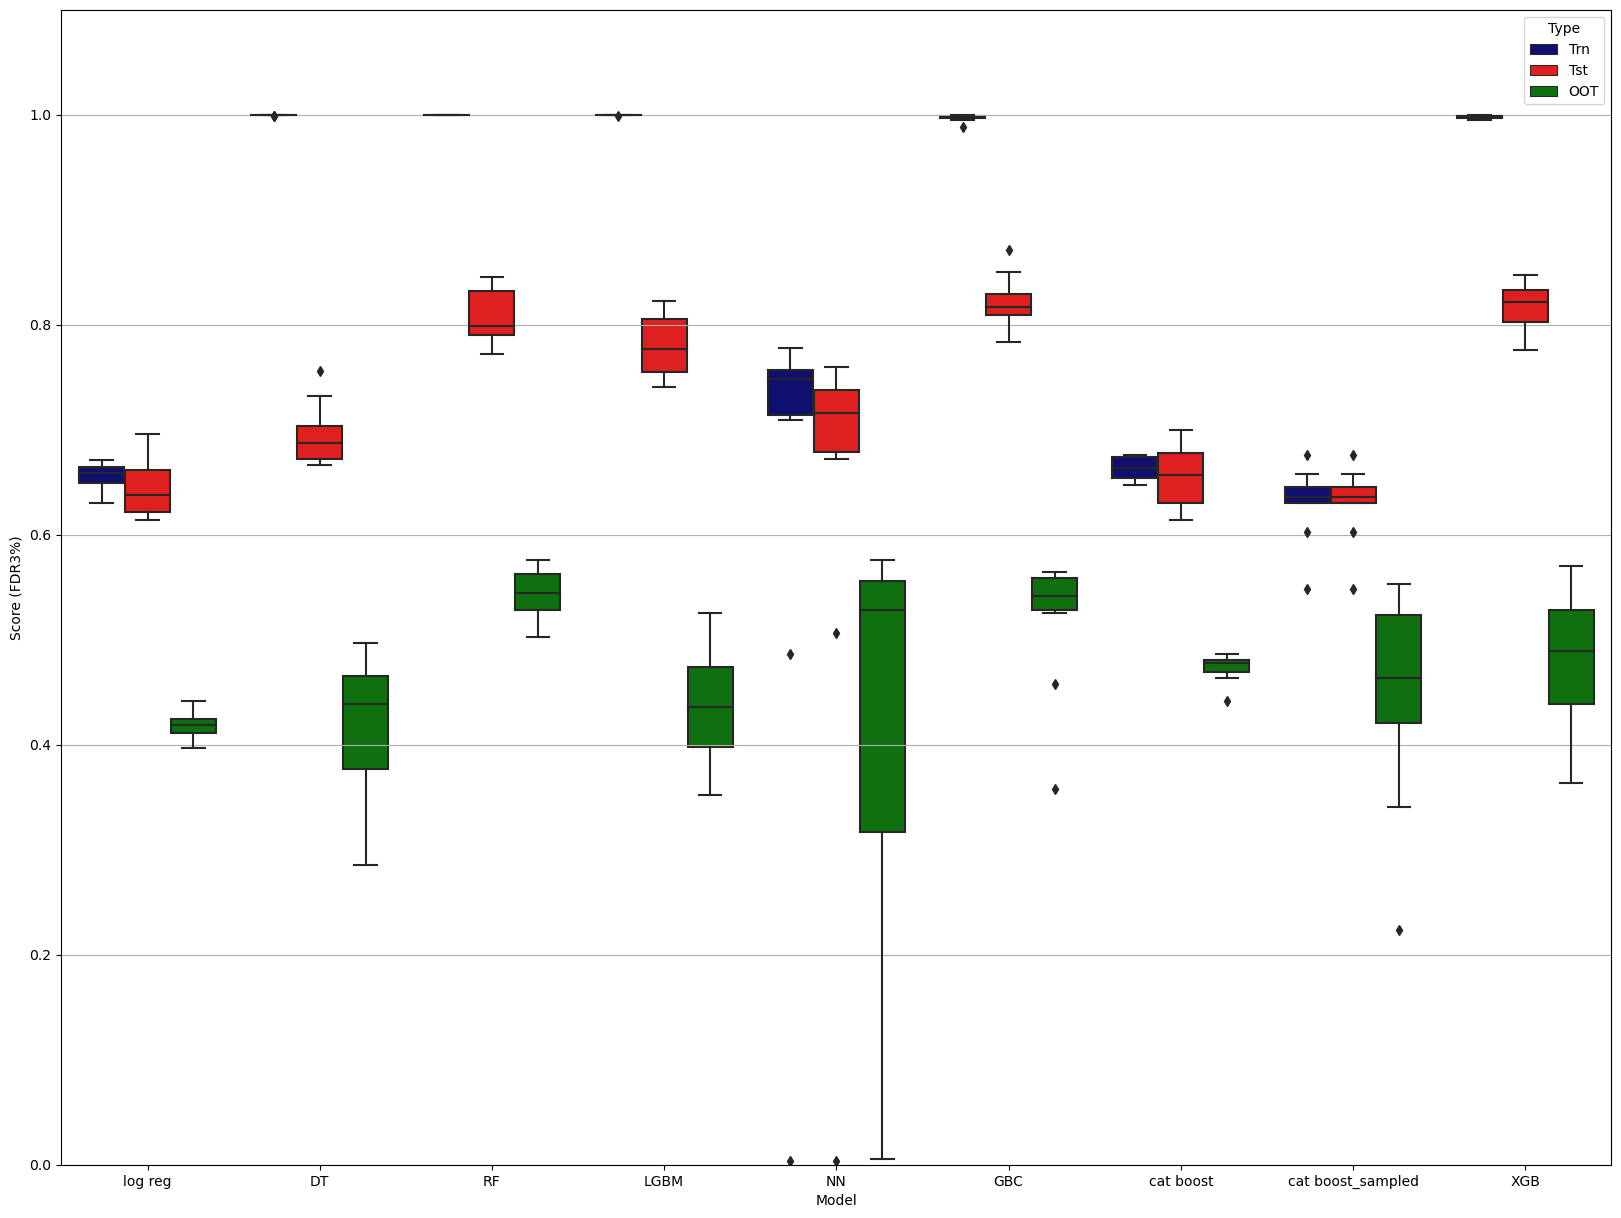

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(0,1.1)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [59]:
print('duration: ', datetime.now() - start_time)

duration:  0:37:56.944730


0 0.2901134521880065 0.30677290836653387 0.20670391061452514
1 0.4786885245901639 0.4728682170542636 0.18435754189944134
2 0.29124579124579125 0.2664233576642336 0.20670391061452514
3 0.48333333333333334 0.458955223880597 0.18435754189944134
4 0.47704918032786886 0.4728682170542636 0.18435754189944134
5 0.49093904448105435 0.45977011494252873 0.18435754189944134
6 0.4866220735785953 0.4740740740740741 0.18435754189944134
7 0.5007974481658692 0.4605809128630705 0.18435754189944134
8 0.3083197389885807 0.23921568627450981 0.20670391061452514
9 0.2814569536423841 0.2840909090909091 0.20670391061452514
loop trn tst oot 1 0.40885655405416477 0.3895619621264984 0.19329608938547488
0 0.5538971807628524 0.6188679245283019 0.24581005586592178
1 0.5333333333333333 0.6640316205533597 0.22905027932960895
2 0.576592082616179 0.5749128919860628 0.24581005586592178
3 0.5836120401337793 0.5555555555555556 0.24581005586592178
4 0.5396290050590219 0.5636363636363636 0.2905027932960894
5 0.57212317666126

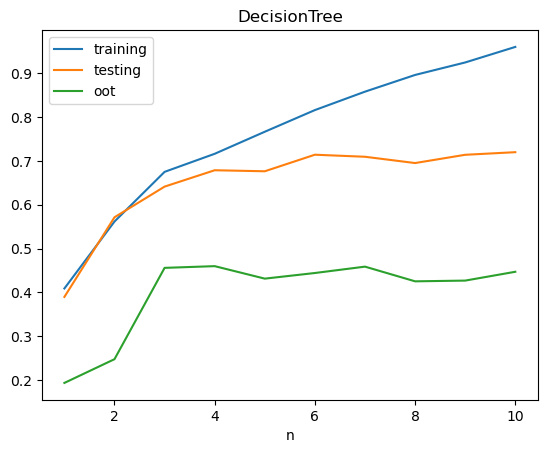

In [60]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,20,2):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = DecisionTreeClassifier(criterion='gini',max_depth=i,min_samples_split=5,min_samples_leaf=5, max_features=10, splitter='best')
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.title('DecisionTree')
plt.savefig('complexity_DecisionTree.pdf', format='pdf')
plt.show()


0 0.7130872483221476 0.7095588235294118 0.553072625698324
1 0.6924265842349304 0.7375565610859729 0.547486033519553
2 0.7197986577181208 0.6764705882352942 0.547486033519553
3 0.6928 0.7160493827160493 0.5363128491620112
4 0.6955810147299509 0.7470817120622568 0.547486033519553
5 0.7172859450726979 0.714859437751004 0.5418994413407822
6 0.6964586846543002 0.7345454545454545 0.5363128491620112
7 0.7212020033388982 0.6728624535315985 0.553072625698324
8 0.7095709570957096 0.6870229007633588 0.5363128491620112
9 0.7400662251655629 0.678030303030303 0.547486033519553
loop trn tst oot 5 0.7098277320332318 0.7074037617250704 0.5446927374301677
0 0.8316666666666667 0.8208955223880597 0.5754189944134078
1 0.8216666666666667 0.8395522388059702 0.5698324022346368
2 0.8314238952536824 0.7937743190661478 0.5754189944134078
3 0.8403908794788274 0.7992125984251969 0.553072625698324
4 0.8449111470113085 0.7991967871485943 0.5698324022346368
5 0.8488964346349746 0.7634408602150538 0.553072625698324
6 

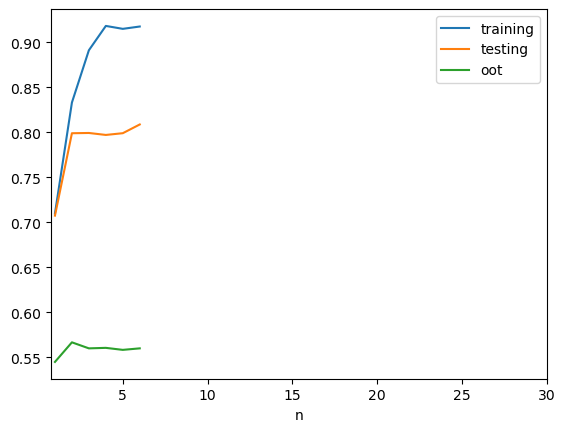

In [61]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(5,31,5):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=i,min_samples_split=25,min_samples_leaf=20,max_features=6)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.savefig('complexity_RandomForest.pdf', format='pdf')
plt.xticks(range(5,31,5))
plt.show()


0 0.648972602739726 0.6830985915492958 0.48044692737430167
1 0.6655462184873949 0.6483516483516484 0.48044692737430167
2 0.6699186991869919 0.6442687747035574 0.4860335195530726
3 0.6683087027914614 0.6833976833976834 0.441340782122905
4 0.662828947368421 0.6692307692307692 0.4860335195530726
5 0.6486042692939245 0.7027027027027027 0.441340782122905
6 0.6579378068739771 0.6575875486381323 0.4581005586592179
7 0.6822742474916388 0.6296296296296297 0.4748603351955307
8 0.6867469879518072 0.6759581881533101 0.4860335195530726
9 0.6672051696284329 0.6506024096385542 0.48044692737430167
loop trn tst oot 2 0.6658343651813776 0.6644827945995284 0.4715083798882681
0 0.6820512820512821 0.6749116607773852 0.48044692737430167
1 0.6645264847512039 0.6530612244897959 0.441340782122905
2 0.634375 0.706140350877193 0.4692737430167598
3 0.6671949286846276 0.6371308016877637 0.4692737430167598
4 0.6705298013245033 0.6401515151515151 0.43575418994413406
5 0.6557093425605537 0.6793103448275862 0.48603351

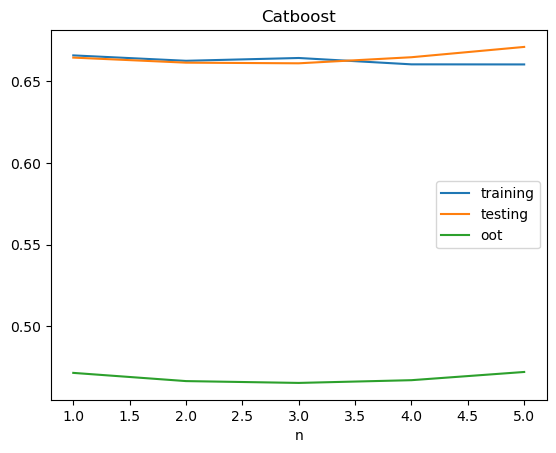

In [62]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(2,11,2):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model =  CatBoostClassifier(verbose=0, max_depth=2, iterations=5)
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.title('Catboost')
plt.savefig('complexity_LGBM', format='pdf')
plt.show()


0 0.7091503267973857 0.69921875 0.5195530726256983
1 0.7294117647058823 0.6776556776556777 0.4134078212290503
2 0.67003367003367 0.708029197080292 0.5363128491620112
3 0.7040816326530612 0.7142857142857143 0.5363128491620112
4 0.7012987012987013 0.6706349206349206 0.5418994413407822
5 0.7102649006622517 0.696969696969697 0.5195530726256983
6 0.659468438538206 0.7180451127819549 0.4692737430167598
7 0.7145187601957586 0.6666666666666666 0.4692737430167598
8 0.697324414715719 0.7074074074074074 0.547486033519553
9 0.690068493150685 0.6549295774647887 0.4134078212290503
loop trn tst oot -4 0.698562110275132 0.691384272094712 0.4966480446927374
0 0.775206611570248 0.7680608365019012 0.45251396648044695
1 0.763458401305057 0.7098039215686275 0.49162011173184356
2 0.77491961414791 0.7032520325203252 0.4581005586592179
3 0.7530017152658662 0.7192982456140351 0.5810055865921788
4 0.7773913043478261 0.764505119453925 0.5251396648044693
5 0.7412353923205343 0.6802973977695167 0.43575418994413406

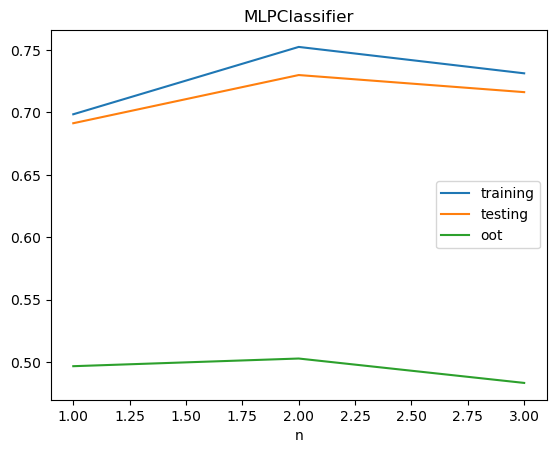

In [63]:
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(-4,-1,1):
    for niter in range(nitermax):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
        
        model = MLPClassifier(hidden_layer_sizes=(20, 20, 20), activation='relu', alpha=0.01, learning_rate='constant', solver='adam', learning_rate_init=10**(i))
        
        model.fit(X_trn, Y_trn.values.ravel()) 

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()
    
        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

table=pd.DataFrame({'n': range(1,len(training)+1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True) 
table.plot()
plt.title('MLPClassifier')
plt.savefig('complexity_NeuralNet', format='pdf')
plt.show()


The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [64]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model =  CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6650485436893204 0.652 0.4860335195530726
1 0.6729131175468483 0.6156583629893239 0.4692737430167598
2 0.6729776247848537 0.6376306620209059 0.4748603351955307
3 0.6838709677419355 0.6854838709677419 0.4748603351955307
4 0.6666666666666666 0.6531365313653137 0.46368715083798884
5 0.6583333333333333 0.6791044776119403 0.48044692737430167
6 0.666131621187801 0.6612244897959184 0.441340782122905
7 0.6521008403361345 0.684981684981685 0.4860335195530726
8 0.5968 0.6337448559670782 0.21787709497206703
9 0.659016393442623 0.6705426356589147 0.48044692737430167
10 0.6578512396694215 0.6806083650190115 0.4748603351955307
11 0.655 0.6828358208955224 0.4581005586592179
12 0.6655405405405406 0.6521739130434783 0.4860335195530726
13 0.6515912897822446 0.6863468634686347 0.4748603351955307
14 0.6829652996845426 0.6794871794871795 0.49162011173184356
15 0.6303236797274276 0.6263345195729537 0.4692737430167598
16 0.6650943396226415 0.6379310344827587 0.4860335195530726
17 0.65 0.6975806451612904 

In [65]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [66]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_zip_total_14,card_zip3_max_30,Card_Merchnum_desc_total_0,card_zip3_max_60,card_merch_total_60,card_zip_max_60,Card_Merchnum_desc_max_60,card_zip_total_30,card_merch_avg_0,card_zip3_total_60,predicted,Fraud
89128,6.991946,2.664042,1.922370,2.472065,6.358058,2.707167,2.823427,6.692423,0.539276,5.568651,0.669053,1
89060,3.513418,2.664042,4.615856,2.472065,3.158325,2.707167,2.823427,3.341684,1.001073,2.717891,0.669053,1
89121,6.879966,2.664042,1.743221,2.472065,6.255053,2.707167,2.823427,6.584557,0.595229,5.476881,0.669053,1
89077,5.217299,2.664042,7.156860,2.472065,4.725645,2.707167,2.823427,4.982970,1.175231,4.114274,0.669053,1
89074,4.975602,2.664042,6.955103,2.472065,4.503318,2.707167,2.823427,4.750152,1.313496,3.916195,0.669053,1
89068,4.266778,2.664042,5.821105,2.472065,3.851305,2.707167,2.823427,4.067368,1.176799,3.335292,0.669053,1
95189,3.931847,5.018242,4.610961,4.709194,2.944325,5.092793,5.278338,3.744741,7.403427,4.411755,0.669053,0
89057,3.289901,2.664042,4.258266,2.472065,2.952722,2.707167,2.823427,3.126378,1.028026,2.534712,0.669053,1
87678,3.853030,14.380956,6.271958,13.606318,3.470718,14.580489,15.041584,3.668820,20.758030,3.042100,0.565648,0
89130,9.063329,6.778209,5.092528,6.381641,8.263425,6.876253,7.113595,8.687710,1.340228,7.266213,0.565648,1


In [67]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,121.0,82.0,39.0,67.768595,32.231405,121.0,82.0,39.0,0.688035,21.787709,21.099675,2.102564
2,2.0,121.0,82.0,39.0,67.768595,32.231405,242.0,164.0,78.0,1.376070,43.575419,42.199349,2.102564
3,3.0,121.0,112.0,9.0,92.561983,7.438017,363.0,276.0,87.0,2.315825,48.603352,46.287527,3.172414
4,4.0,121.0,121.0,0.0,100.000000,0.000000,484.0,397.0,87.0,3.331096,48.603352,45.272256,4.563218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,121.0,121.0,0.0,100.000000,0.000000,11613.0,11434.0,179.0,95.938916,100.000000,4.061084,63.877095
97,97.0,121.0,121.0,0.0,100.000000,0.000000,11734.0,11555.0,179.0,96.954187,100.000000,3.045813,64.553073
98,98.0,121.0,121.0,0.0,100.000000,0.000000,11855.0,11676.0,179.0,97.969458,100.000000,2.030542,65.229050
99,99.0,121.0,121.0,0.0,100.000000,0.000000,11976.0,11797.0,179.0,98.984729,100.000000,1.015271,65.905028


In [68]:
FDR3.to_csv('FDR3.csv')

In [69]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [70]:
print("duration: ", datetime.now() - start_time)

duration:  0:54:38.766287


Max possible savings: 17,568,000.0


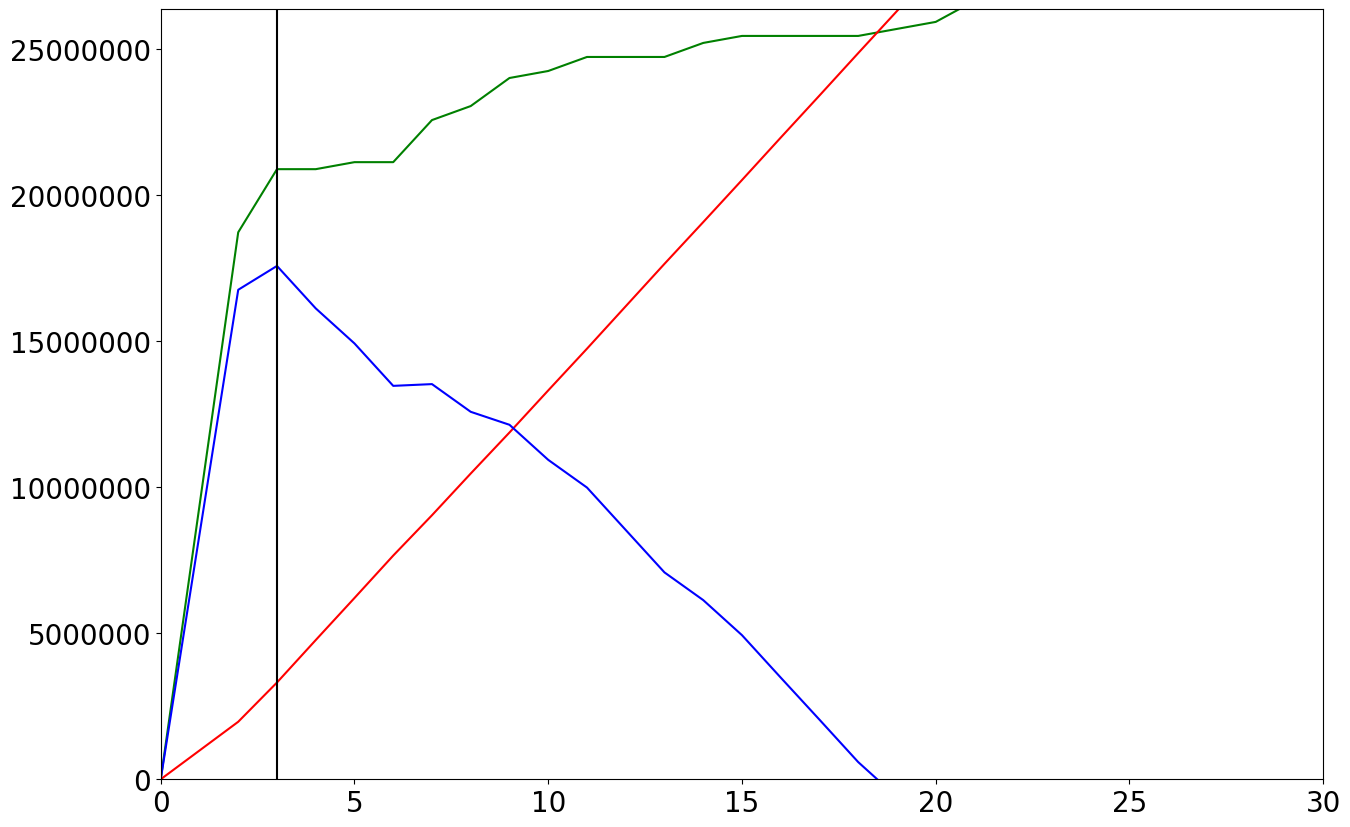

In [71]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.axvline(x = 3, color = 'black')
plt.savefig('savings.png', format='png')